In [1]:
import sys

import jax
import jax.numpy as jnp
import numpyro.distributions as dist
import matplotlib.pyplot as plt


from berrylib.constants import Y_I, Y_I2, N_I, N_I2
from jax.config import config
config.update("jax_enable_x64", False)



/home/const/mambaforge/envs/imprint/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
import numpy as np
import berrylib.fast_inla
import importlib
from functools import partial

importlib.reload(berrylib.fast_inla)
from berrylib.fast_inla import FastINLA, jax_opt, jax_faster_inv_product

def jax_faster_inv_product(D, S, G):
    """Compute (diag(D)+S)^-1 @ G.

    This function uses "Sherman-Morrison" formula:
    https://en.wikipedia.org/wiki/Sherman–Morrison_formula
    """
    D_inverse = 1.0 / D
    multiplier = -S / (1 + (S / D).sum())
    # return D_inverse *(multiplier * jnp.dot(D_inverse, G) +  G)
    D_norm = jnp.abs(D).sum()
    D_normed = D / D_norm
    return (-S * (G / D_normed).sum() / (D_norm + (S  / D_normed).sum()) + G) / D

Ds = jnp.arange(3, -7, -1)
S = 100
G = jnp.arange(1, 5)
for D in Ds:
    D = 10.0**D
    print('D', D)
    D = jnp.repeat(D, 4)
    D_inverse = 1.0 / D
    multiplier = -S / (1 + (S / D).sum())
    d_multiplier = -S / (D + S*len(D))
    a, b = D_inverse *(multiplier * jnp.dot(D_inverse, G)), D_inverse * G
    # print("inv", D_inverse)
    # print(multiplier * D_inverse)
    # print(d_multiplier)
    print(jax_faster_inv_product(D, S, G))
    # print(jax_faster_inv_product(D, S, G) * D)
# assert jax.config.read("jax_enable_x64")

# fi = FastINLA(n_arms=4)
# # sigma2 = jnp.array(1e5)
# y = jnp.array([0, 0, 30, 30])
# n = jnp.array([30, 30, 30, 30])
# # # fi.jax_inference(y, n)
# j = -2
# jax_opt(
#     y,
#     n,
#     fi.sigma2_pts_jax[j],
#     fi.neg_precQ_jax[j],
#     fi.precQ_eig_vals_jax[j],
#     fi.precQ_eig_vecs_jax[j],
#     fi.logit_p1,
#     fi.mu_0,
#     fi.tol,
#     fast_loop=False,
# )


D 1000.0
[0.00028571 0.00128571 0.00228571 0.00328571]
D 100.0
[-0.01  0.    0.01  0.02]
D 10.0
[-0.14390244 -0.04390244  0.05609756  0.15609756]
D 1.0
[-1.49376559 -0.49376559  0.50623441  1.50623441]
D 0.1
[-14.99375156  -4.99375156   5.00624844  15.00624844]
D 0.01
[-149.99375016  -49.99375016   50.00624984  150.00624984]
D 0.001
[-1499.99375002  -499.99375002   500.00624998  1500.00624998]
D 0.0001
[-14999.99375  -4999.99375   5000.00625  15000.00625]
D 1e-05
[-149999.99375  -49999.99375   50000.00625  150000.00625]
D 1e-06
[-1499999.99375  -499999.99375   500000.00625  1500000.00625]


In [164]:
with open("/home/const/imprint/out.txt") as f:
    arr = np.array(eval(f.read()))
arr.shape
np.linalg.slogdet(arr)


(array([[ 0.,  0., -1., ...,  1.,  1.,  1.],
        [ 0.,  0., -1., ...,  1.,  1.,  1.],
        [ 0.,  0., -1., ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([[        -inf,         -inf,  -7.11662666, ...,   6.93373191,
           8.5175151 ,   8.87252596],
        [        -inf,         -inf,  -7.11662666, ...,   6.93373191,
           8.5175151 ,   8.87252596],
        [        -inf,         -inf,  -7.11662666, ...,   6.93373191,
           8.5175151 ,   8.87252596],
        ...,
        [-15.78124253, -15.25253092, -14.32642149, ...,   1.32578601,
           2.18722541,   2.42099027],
        [-15.81360094, -15.28283245, -14.3575988 , ...,  -2.60645969,
          -2.60283052,  -2.60188043],
        [-15.83460559, -15.30497092, -14.383241  , ...,  -3.23427153,
          -3.23251662,  -3.23205077]]))

In [18]:
# with jit:
x = np.array([2.3373992443084717, 2.337362289428711])
y = np.array([2.3381409645080566, 2.338103771209717])

def 

# without jit:
# [2.3373985290527344, 2.3373618125915527]
print(np.linalg.norm(x - y))
print(np.abs(x-y))


0.0010487821918949499
[0.00074172 0.00074148]


In [61]:
def logit(x):
    return jnp.log(x) - jnp.log(1 - x)


def get_log_berry_likelihood(y, n):
    def log_berry_likelihood(theta, sigma_sq):
        ll = 0.0
        ll += dist.InverseGamma(0.0005, 0.000005).log_prob(sigma_sq)
        cov = jnp.full((4, 4), 100) + jnp.diag(jnp.repeat(sigma_sq, 4))
        ll += (
            dist.MultivariateNormal(-1.34, covariance_matrix=cov).log_prob(theta).sum()
        )
        ll += dist.BinomialLogits(logit(0.3) + theta, total_count=n).log_prob(y).sum()
        return ll

    return log_berry_likelihood


ll = get_log_berry_likelihood(y, n)
theta = jnp.array([0.0, 0, 0, 0])
sigma_sq = 1e1
ll(theta, sigma_sq)
grad = jax.grad(ll, 0)
hess = jax.jacobian(grad)
h = hess(theta, sigma_sq)
print(h)
print(jnp.linalg.inv(h))


[[-6.37561     0.02439026  0.02439024  0.02439024]
 [ 0.02439026 -6.37561     0.02439026  0.02439025]
 [ 0.02439025  0.02439026 -6.37561     0.02439024]
 [ 0.02439025  0.02439025  0.02439024 -6.37561   ]]
[[-0.1568547  -0.00060468 -0.00060468 -0.00060468]
 [-0.00060468 -0.15685467 -0.00060468 -0.00060468]
 [-0.00060468 -0.00060468 -0.15685469 -0.00060468]
 [-0.00060468 -0.00060468 -0.00060468 -0.15685469]]


In [ ]:
def mcmc_berry_model(y, n):
    # y, n = data
    mu = numpyro.sample("mu", dist.Normal(-1.34, 10))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(0.0005, 0.000005))
    with numpyro.plate("j", 4):
        theta = numpyro.sample(
            "theta",
            dist.Normal(mu, jax.numpy.sqrt(sigma2)),
        )
        numpyro.sample(
            "y",
            dist.BinomialLogits(theta + 0, total_count=n),
            obs=y,
        )


# Stochastic Variational Inference

In [ ]:
import numpyro
from functools import partial
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_uniform
from numpyro.contrib.einstein import RBFKernel, SteinVI
from numpyro.infer.autoguide import (
    AutoLaplaceApproximation,
    AutoDelta,
    AutoMultivariateNormal,
    AutoBNAFNormal,
)

data = Y_I2[-1], N_I2[-1]
y, n = data
model = mcmc_berry_model
optimizer = numpyro.optim.Adam(step_size=0.005)
# guide = AutoLaplaceApproximation(model)
guide = AutoBNAFNormal(model)
# guide = AutoMultivariateNormal(model)
# guide = AutoDelta(model, init_loc_fn=partial(init_to_uniform, radius=0.1))
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), 3_000, y, n)
params = svi_result.params
predictive = Predictive(guide, params=params, num_samples=100000)
samples = predictive(jax.random.PRNGKey(1), data)


100%|██████████| 3000/3000 [00:02<00:00, 1104.55it/s, init loss: 78.8034, avg. loss [2851-3000]: 19.7578]


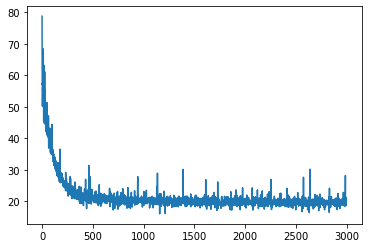

In [ ]:
plt.plot(svi_result.losses)


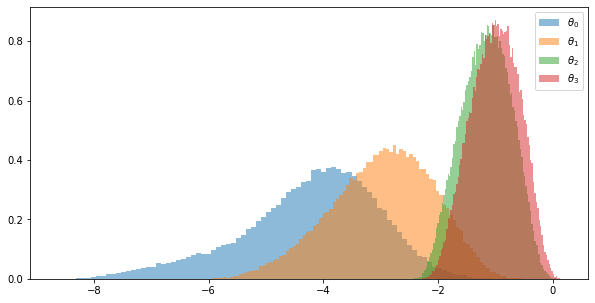

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(4):
    s = samples["theta"][:, i]
    s = s[jnp.newaxis]
    plt.hist(s, bins=100, density=True, label=f"$\\theta_{i}$", alpha=0.5)
plt.legend()
None


$ P(x_i | x_{-i}, y, \theta) = P(x, y, \theta) / P(x_{-i}, \theta, y) $

2) gaussian approx at x=mu(theta)

* p_thetaIy = log_berry_likelihood(vars) - p_x_I_theta_y  

* Note the last term depends on a fixed theta too

2) p_thetaIy = log_berry_likelihood(vars) - .5 * log(-H(f(x_0)))  

3) p_xiIy = sum(p_xiItheta_y + p_thetaIy for theta in thetas)

* times dTheta

* p_xiItheta_y is skew normal approximation at MAP

$ P(t|y) = P(x, t, y) / gaussian(P(x | t, y)) $

$ P(x_i|t,y) = P(x, t, y) / gaussian(P(x-i|t,y)) $

$ P(x_i | y) = \sum(P(xi|t,y) * P(t|y) \Delta t) $

$ P(x_i | y) = \sum(P(xi|t,y) * P(t|y) \Delta t) $

In [ ]:
y = Y_I2[-1]
n = N_I2[-1]
log_berry_likelihood = get_log_berry_likelihood(y, n)
grad = jax.grad(log_berry_likelihood, 0)
hess = jax.jacobian(grad)
# theta = jnp.zeros(4)
key = jax.random.PRNGKey(0)
theta = jax.random.uniform(key, [4])
mu = jnp.zeros(1)
sigma = jnp.array(0.01)[jnp.newaxis]
vars = jnp.concatenate([theta, mu, sigma])
print(vars.shape)
jnp.exp(log_berry_likelihood(vars))
grad(vars)
h = hess(vars)
h


(6,)


DeviceArray([[-1.03994812e+02,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  1.00000000e+02,  9.65321387e+03],
             [ 0.00000000e+00, -1.04937164e+02,  0.00000000e+00,
               0.00000000e+00,  1.00000000e+02,  2.25158911e+03],
             [ 0.00000000e+00,  0.00000000e+00, -1.07928795e+02,
               0.00000000e+00,  1.00000000e+02,  6.33029883e+03],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              -1.08560623e+02,  1.00000000e+02,  2.96381812e+03],
             [ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
               1.00000000e+02, -4.00010010e+02, -2.11989219e+04],
             [ 9.65321289e+03,  2.25158911e+03,  6.33029883e+03,
               2.96381812e+03, -2.11989180e+04, -1.44111600e+06]],            dtype=float32)

In [ ]:
N_ARMS = 4


def pack_vars(theta, mu, sigma):
    return jnp.concatenate([theta, mu, sigma])


def unpack_vars(vars):
    return vars[:N_ARMS], vars[N_ARMS], vars[N_ARMS + 1]


# print(hs.shape)
@jax.jit
def chol():
    hs = jnp.stack([h for i in range(4 * 16)])
    return jax.lax.linalg.cholesky(
        hs,
    )
    # return jnp.linalg.inv(hs)


# %timeit chol()

# @jax.jit
def optimize(theta, sigma, mask):
    log_berry_likelihood = get_log_berry_likelihood(y, n)
    grad = jax.grad(log_berry_likelihood, 0)
    hess = jax.jacobian(grad)
    # theta = jnp.zeros(4)
    mu = jnp.zeros(1)
    sigma = jnp.array(sigma)[jnp.newaxis]
    vars = pack_vars(theta, mu, sigma)
    # Do a newton iteration
    pvars = None
    for _ in range(10):
        g = grad(vars)
        h = hess(vars)
        g = g[mask]
        h = h[mask, mask]
        pvars = vars
        print(jnp.diag(h))
        update = jnp.linalg.solve(h, g)
        vars = vars.at[mask].add(-update)
        # assert not jnp.isnan(vars).any()
        # print(jnp.linalg.norm(pvars - vars))
    return vars


In [ ]:
theta = jnp.zeros(4)
sigma = 1e-8
mask = jnp.s_[0:5]
optimize(theta, sigma, mask)


[-1.0000001e+08 -1.0000001e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000001e+08 -1.0000001e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000001e+08 -1.0000001e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]
[-1.0000000e+08 -1.0000000e+08 -1.0000001e+08 -1.0000001e+08
 -4.0000000e+08]


DeviceArray([-1.5039762e+00, -1.5039762e+00, -1.5039762e+00,
             -1.5039761e+00, -1.5039762e+00,  9.9999999e-09],            dtype=float32)

In [ ]:
sigmas = jnp.power(10, jnp.linspace(-8, 3, 10))
thetas = jnp.linspace(-10, 10, 10)
mask = jnp.s_[1:5]
varss = []
for sigma in sigmas:
    for theta in thetas:
        theta = jnp.zeros(4).at[0].set(theta)
        vars = optimize(theta, sigma, mask)
        varss.append(vars)
varss = jnp.stack(varss)


In [ ]:
varss.shape


(100, 6)

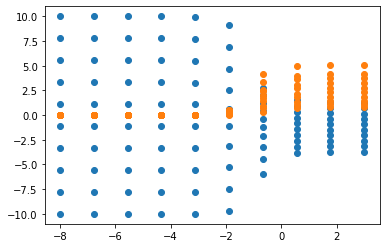

In [ ]:
sigmas = jnp.log10(varss[:, N_ARMS + 1])
thetas = varss[:, :N_ARMS]
plt.scatter(sigmas, jnp.mean(thetas, 1))
plt.scatter(sigmas, jnp.std(thetas, 1))


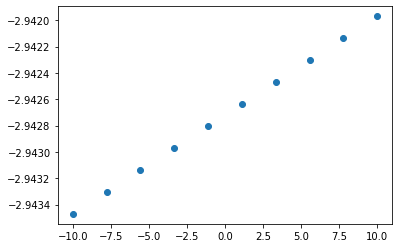

In [ ]:
x = 90
plt.scatter(thetas[x : x + 10, 0], thetas[x : x + 10, 1])


In [ ]:
thetas[x : x + 10]


DeviceArray([[-2.9434702 , -1.0610158 , -0.91644555],
             [-2.9433036 , -1.0609921 , -0.9164234 ],
             [-2.943137  , -1.0609684 , -0.91640127],
             [-2.9429703 , -1.0609446 , -0.916379  ],
             [-2.9428034 , -1.0609208 , -0.91635674],
             [-2.9426367 , -1.0608972 , -0.91633445],
             [-2.94247   , -1.0608734 , -0.9163123 ],
             [-2.9423037 , -1.0608497 , -0.91629004],
             [-2.942137  , -1.060826  , -0.9162678 ],
             [-2.9419703 , -1.0608022 , -0.91624564]], dtype=float32)

In [ ]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


def mcmc_berry_model(y, n):
    mu = numpyro.sample("mu", dist.Normal(-1.34, 10))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(0.0005, 0.000005))
    with numpyro.plate("j", 2):
        theta = numpyro.sample(
            "theta",
            dist.Normal(mu, jax.numpy.sqrt(sigma2)),
        )
        numpyro.sample(
            "y",
            dist.BinomialLogits(theta + (np.log(0.3) - np.log(1 - 0.3)), total_count=n),
            obs=y,
        )


def do_mcmc(rng_key, y, n):
    nuts_kernel = NUTS(mcmc_berry_model)
    mcmc = MCMC(
        nuts_kernel,
        progress_bar=False,
        num_warmup=10_000,
        num_samples=1_000_000,
        thinning=10,
    )
    mcmc.run(rng_key, y, n)
    return mcmc.get_samples(group_by_chain=True)


s = do_mcmc(jax.random.PRNGKey(0), jnp.array([4, 8]), jnp.array([35, 35]))


/Users/alexconstantino/.local/share/virtualenvs/research-pVCP8Qup/lib/python3.8/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


[0.06822955]
(100000,)


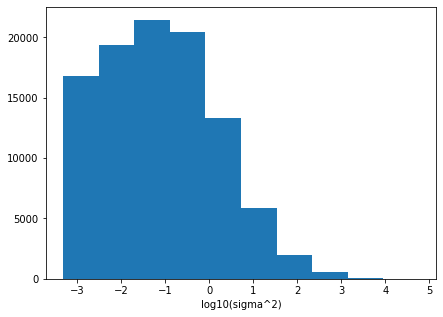

In [ ]:
sig = s["sigma2"]
# sig = sig[np.newaxis]
sig = sig[:, :][0]
print(np.quantile(sig, [0.5]))
sig = np.log10(sig)
print(sig.shape)
fig = plt.figure(figsize=(7, 5))
plt.hist(sig, bins=10)
plt.xlabel("log10(sigma^2)")
fig.patch.set_alpha(1)


In [ ]:
def jax_calc_posterior_and_exceedances(
    theta_max,
    y,
    n,
    log_prior,
    neg_precQ,
    logprecQdet,
    hess_inv,
    sigma2_wts,
    logit_p1,
    mu_0,
    thresh_theta,
):
    theta_m0 = theta_max - mu_0
    theta_adj = theta_max + logit_p1
    exp_theta_adj = jnp.exp(theta_adj)
    logjoint = (
        0.5 * jnp.einsum("...i,...ij,...j", theta_m0, neg_precQ, theta_m0)
        + logprecQdet
        + jnp.sum(
            theta_adj * y[:, None] - n[:, None] * jnp.log(exp_theta_adj + 1),
            axis=-1,
        )
        + log_prior
    )

    log_sigma2_post = logjoint + 0.5 * jnp.log(jnp.linalg.det(-hess_inv))
    sigma2_post = jnp.exp(log_sigma2_post)
    sigma2_post /= jnp.sum(sigma2_post * sigma2_wts, axis=1)[:, None]

    theta_sigma = jnp.sqrt(jnp.diagonal(-hess_inv, axis1=2, axis2=3))
    exc_sigma2 = 1.0 - jax.scipy.stats.norm.cdf(
        thresh_theta,
        theta_max,
        theta_sigma,
    )
    exceedances = jnp.sum(
        exc_sigma2 * sigma2_post[:, :, None] * sigma2_wts[None, :, None], axis=1
    )
    return sigma2_post, exceedances
